In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
import sys
sys.path.append("../") # path to ssgp root directory

In [3]:
import ssgp

In [4]:
def plot_pred(model,X_test,n_std = 1,plot_data=True):
    """
    Auxiliary function to plot 1-D GP predictions.
    """
    if plot_data and model.X is not None:
        plt.plot(model.X.numpy(),model.Y.numpy(),'k+',ms=10,label="observations")
    mean_test, var_test = model.predict(X_test)
    plt.plot(X_test.numpy(),mean_test.numpy(),'b-',label="GP")
    stddev_test = np.sqrt(var_test.numpy().diagonal())
    plt.fill_between(X_test.numpy().ravel(),
                     mean_test.numpy().ravel()-n_std*stddev_test,
                     mean_test.numpy().ravel()+n_std*stddev_test,alpha=0.2)

# A simple 1-D example

In [5]:
def example_function(x):
    return torch.norm(x,dim=1)**2

In [6]:
dim = 1
n_freqs = 200
model = ssgp.models.ISSGPR(n_freqs,dim,
                           lengthscale=1.,
                           noise_stddev=0.1,
                           signal_stddev=5.,
                           kernel_type="matern5",
                           mean_function=ssgp.mean_functions.ConstantMean(1.))

In [7]:
n_train = 30
X = torch.randn(n_train,dim)*2
y = example_function(X)[:,None]+torch.randn(n_train,1)*0.5
model.set_data(X,y)

(-5, 25)

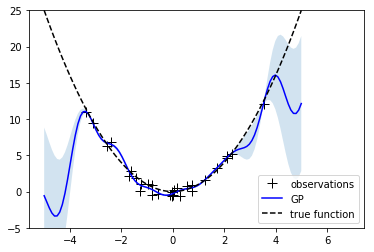

In [8]:
n_test = 100
Xq = torch.linspace(-5,5,n_test)[:,None]
plot_pred(model,Xq,n_std=2)
plt.plot(Xq.numpy(),example_function(Xq).numpy(),'k--',label="true function")
plt.legend()
plt.ylim(-5,25)

## Length-scale tuning

In [9]:
import nlopt

In [10]:
n_steps = 50
n_hp = 2

hp_lower_bounds=np.asarray([1.,0.])
hp_upper_bounds=np.asarray([10.,50.])

nlopt_obj = ssgp.tuning.NLoptTuningObjective(model,["lengthscale","mean_params"],compute_grad=True) # length-scale is mandatory to be included

hp_opt = nlopt.opt(nlopt.LD_MMA,n_hp)
hp_opt.set_lower_bounds(hp_lower_bounds)
hp_opt.set_upper_bounds(hp_upper_bounds)
hp_opt.set_min_objective(nlopt_obj)
hp_opt.set_maxeval(n_steps)

initial_hp = np.random.uniform(low=hp_lower_bounds,high=hp_upper_bounds)
print("Initial setting:", initial_hp)

print("Optimising hyperparmeters...")
final_hp = hp_opt.optimize(initial_hp)

model.set_hyperparameters(**nlopt_obj.hp_map(final_hp))
print("GP hyperparameters: {}\n".format(model.get_hyperparameters()))

Initial setting: [ 5.85289408 37.00535004]
Optimising hyperparmeters...
GP hyperparameters: tensor([ 1.9389,  5.0000,  0.1000, 18.6740])



(-5, 25)

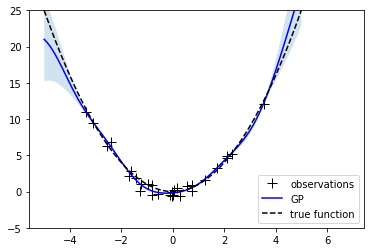

In [11]:
plot_pred(model,Xq,n_std=2)
plt.plot(Xq.numpy(),example_function(Xq).numpy(),'k--',label="true function")
plt.legend()
plt.ylim(-5,25)